# Import libs

In [3]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline
import time
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import numpy as np
from models import *
import cv2
import torch
import torch.optim

from skimage.metrics import structural_similarity as compare_ssim
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from utils.denoising_utils import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

imsize =-1
PLOT = True
sigma = 25
sigma_ = sigma/255.

/root/miniconda3/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/root/miniconda3/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [4]:
# deJPEG 
# fname = 'data/denoising/snail.jpg'

## denoising
fname = 'data/denoising/F16_GT.png'

# Load image

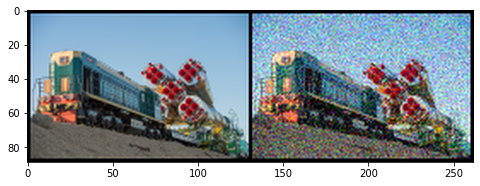

In [5]:
# deJPEG 
# fname = 'data/denoising/snail.jpg'

## denoising
fname = '/root/autodl-tmp/INCODE-main/data/image/0720.png'
im = plt.imread(fname).astype(np.float32)*255
im = cv2.resize(im, None, fx=1/16, fy=1/16, interpolation=cv2.INTER_AREA)
# img_pil = crop_image(get_image(fname, imsize)[0], d=32)
img_pil =im
img_np = pil_to_np(img_pil)

img_noisy_pil, img_noisy_np = get_noisy_image(img_np, sigma_)

if PLOT:
    plot_image_grid([img_np, img_noisy_np], 4, 6);

# Setup

In [6]:
# INPUT = 'noise' # 'meshgrid'
# pad = 'reflection'
# OPT_OVER = 'net' # 'net,input'

# reg_noise_std = 1./30. # set to 1./20. for sigma=50
# LR = 0.01

# OPTIMIZER='adam' # 'LBFGS'
# show_every = 100
# exp_weight=0.99

# if fname == 'data/denoising/snail.jpg':
#     num_iter = 2400
#     input_depth = 3
#     figsize = 5 
    
#     net = skip(
#                 input_depth, 3, 
#                 num_channels_down = [8, 16, 32, 64, 128], 
#                 num_channels_up   = [8, 16, 32, 64, 128],
#                 num_channels_skip = [0, 0, 0, 4, 4], 
#                 upsample_mode='bilinear',
#                 need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU')

#     net = net.type(dtype)

# elif fname == 'data/denoising/F16_GT.png':
#     num_iter = 3000
#     input_depth = 32 
#     figsize = 4 
    
    
#     net = get_net(input_depth, 'skip', pad,
#                   skip_n33d=128, 
#                   skip_n33u=128, 
#                   skip_n11=4, 
#                   num_scales=5,
#                   upsample_mode='bilinear').type(dtype)

# else:
#     assert False
    
# net_input = get_noise(input_depth, INPUT, (img_pil.size[1], img_pil.size[0])).type(dtype).detach()

# # Compute number of parameters
# s  = sum([np.prod(list(p.size())) for p in net.parameters()]); 
# print ('Number of params: %d' % s)

# # Loss
# mse = torch.nn.MSELoss().type(dtype)

# img_noisy_torch = np_to_torch(img_noisy_np).type(dtype)







In [7]:
INPUT = 'noise' # 'meshgrid'
pad = 'reflection'
OPT_OVER = 'net' # 'net,input'

reg_noise_std = 1./25. # set to 1./20. for sigma=50
LR = 0.001

OPTIMIZER='adam' # 'LBFGS'
show_every = 100
exp_weight=0.99

num_iter = 5001
input_depth = 64
figsize = 4 


net = get_net(input_depth, 'skip', pad,
                skip_n33d=192, 
                skip_n33u=192, 
                skip_n11=4, 
                num_scales=5,
                upsample_mode='bilinear').type(dtype)
net_input = get_noise(input_depth, INPUT, (img_pil.shape[0], img_pil.shape[1])).type(dtype).detach()

# Compute number of parameters
s  = sum([np.prod(list(p.size())) for p in net.parameters()]); 
print ('Number of params: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)

img_noisy_torch = np_to_torch(img_noisy_np).type(dtype)


RuntimeError: The NVIDIA driver on your system is too old (found version 11070). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver.

# Optimize

In [ ]:

net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()
out_avg = None
last_net = None
psrn_noisy_last = 0

i = 0
truth_psnr = []
noise_psnr = []
cumulative_times = []
best_img = None  # 在全局范围内声明best_img
start_time = time.time()

def closure():
    global i, out_avg, psrn_noisy_last, last_net, net_input, best_img, truth_psnr
    
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)
    
    out = net(net_input)
    
    # Smoothing
    if out_avg is None:
        out_avg = out.detach()
    else:
        out_avg = out_avg * exp_weight + out.detach() * (1 - exp_weight)
            
    total_loss = mse(out, img_noisy_torch)
    total_loss.backward()
    
    psrn_noisy = compare_psnr(img_noisy_np, out.detach().cpu().numpy()[0]) 
    psrn_gt    = compare_psnr(img_np, out.detach().cpu().numpy()[0]) 
    psrn_gt_sm = compare_psnr(img_np, out_avg.detach().cpu().numpy()[0]) 
    truth_psnr.append(psrn_gt)
    noise_psnr.append(psrn_noisy)
    
    print ('Iteration %05d    Loss %f   PSNR_noisy: %f   PSRN_gt: %f PSNR_gt_sm: %f' % (i, total_loss.item(), psrn_noisy, psrn_gt, psrn_gt_sm), '\r', end='')
    
    # 如果当前PSNR比之前的最佳PSNR更高，则更新best_img
    if best_img is None or psrn_gt > max(truth_psnr[:-1]):  # -1 to exclude the current psnr_gt just appended
        best_img = torch_to_np(out).copy()
    
    current_total_time = time.time() - start_time
    cumulative_times.append(current_total_time)
    i += 1

    return total_loss

p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

# 在循环结束后，你可以直接访问best_img
print("Best image obtained:")
# 这里可以添加显示或保存best_img的代码，例如：
# import matplotlib.pyplot as plt
# plt.imshow(best_img)
# plt.show()


Starting optimization with ADAM


  0%|          | 0/5001 [00:00<?, ?it/s]

Best image obtained:oss 0.000248   PSNR_noisy: 36.048787   PSRN_gt: 20.443700 PSNR_gt_sm: 20.564585  


In [ ]:
save_name='/root/autodl-tmp/HOIN/Result/denoise/'+'DIP'+'_clean_epoch.npy'
np.save(save_name,np.array(truth_psnr))

save_name='/root/autodl-tmp/HOIN/Result/denoise/'+'DIP'+'_noise_epoch.npy'
np.save(save_name,np.array(noise_psnr))

save_name='/root/autodl-tmp/HOIN/Result/denoise/'+'DIP'+'_time.npy'
np.save(save_name,np.array(cumulative_times))


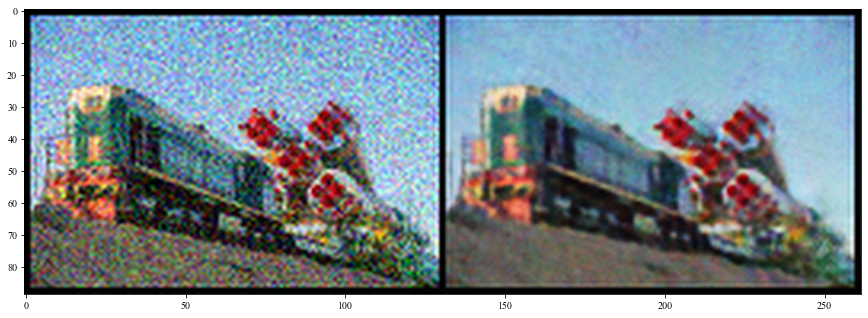

In [ ]:
out_np = torch_to_np(net(net_input))
q = plot_image_grid([np.clip(out_np, 0, 1), best_img], factor=13);

In [ ]:
# best_img_save_name='/root/autodl-tmp/HOIN/Result/denoise/'+'DIP'+'_best_img.png'
# cv2.imwrite('/root/autodl-tmp/HOIN/Result/denoise/im.png',img_np*255)
# cv2.imwrite('/root/autodl-tmp/HOIN/Result/denoise/im_noisy.png',img_noisy_np*255)
# cv2.imwrite(best_img_save_name,best_img[:,:, ::-1]*255)
# tmax=0.15
# plt.style.use('default')

# image1 = cv2.imread('/root/autodl-tmp/HOIN/Result/denoise/im_noisy.png')
# image2 = cv2.imread(best_img_save_name)

# # 确保图像为同一尺寸
# image1 = cv2.resize(image1, (image2.shape[1], image2.shape[0]))

# # 计算差异
# difference = cv2.absdiff(image1, image2)

# # 将差异转换为灰度图，以便更清晰地看到差异
# gray_difference = cv2.cvtColor(difference, cv2.COLOR_BGR2GRAY)/255

# # 显示差异
# plt.figure(figsize=(20, 20))
# plt.subplot(1, 3, 1), plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
# plt.title('Image 1'), plt.xticks([]), plt.yticks([])

# plt.subplot(1, 3, 2), plt.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
# plt.title('Image 2'), plt.xticks([]), plt.yticks([])

# plt.subplot(1, 3, 3), plt.imshow(gray_difference, cmap='jet',vmin=0,vmax=tmax)
# plt.title('Difference'), plt.xticks([]), plt.yticks([])

# # # best_img_save_name='/root/autodl-tmp/INCODE-main/result/image_denoise/'+args.inr_model+'_best_img_inferno.png'
# # fig = plt.figure()
# # plt.imshow(gray_difference, cmap='inferno',vmin=0,vmax=tmax)
# # plt.axis('off')
# # # plt.savefig(best_img_save_name,format='png',dpi=2000,bbox_inches='tight', pad_inches=0)
# # plt.show()

# import numpy as np
# from matplotlib import pyplot as plt
# from PIL import Image

# # 步骤1: 加载图像并转换为灰度图像
# image_path = best_img_save_name  # 替换为你的图像文件路径
# image = Image.open(image_path).convert('L')

# # 步骤2: 将图像转换为numpy数组
# image_array = np.asarray(image)

# # 步骤3: 应用二维FFT并将零频率分量移到中心
# fft_result = np.fft.fftshift(np.fft.fft2(image_array))

# # 步骤4: 计算幅度谱，并应用对数尺度进行可视化
# magnitude_spectrum = np.log(np.abs(fft_result) + 1)

# # 步骤5: 绘制频谱图
# plt.figure(figsize=(6, 6))
# plt.grid(False)
# plt.imshow(magnitude_spectrum, cmap='jet',vmin=0,vmax=TMAX)
# # plt.colorbar()
# plt.axis('off') 
# best_img_save_name='/root/autodl-tmp/HOIN/Result/denoise/'+args.inr_model+'_best_img_sb.png'
# plt.savefig(best_img_save_name, bbox_inches='tight', pad_inches=0.0, dpi=160)
# plt.show()




# font = {'font': 'Times New Roman', 'size': 14}
# plt.style.use('default')
# fig = plt.figure(figsize=(15.0/2.54, 12/2.54))
# axfont = {'family' : 'Times New Roman', 'weight' : 'regular', 'size'   : 11}
# plt.rc('font', **axfont)
# for i, model_name in enumerate(model_psnr):
#     psnr_num=model_psnr[model_name]
#     plt.plot(np.arange(len(psnr_num[:-1])), psnr_num[:-1], linewidth=1.5,label = f"{(model_name).upper()}")
# plt.xlabel('# Epoch', fontdict=font)
# plt.ylabel('PSNR (dB)', fontdict=font)
# # plt.ylim(16,30.5)
# plt.title('Image Representation', fontdict={'family': 'Times New Roman', 'size': 14, 'weight': 'bold'})
# plt.legend(fancybox=True, shadow=True, ncol=2)
# plt.grid(True, color='lightgray')
# plt.tight_layout()  # 调整整体布局
# # plt.savefig("/root/autodl-tmp/INCODE-main/result/image_denoise/psnr.png",format='png',dpi=2000,bbox_inches='tight', pad_inches=0)
# plt.show()






No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


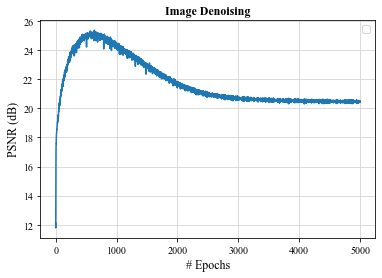

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Max PSNR: 25.367763225698916


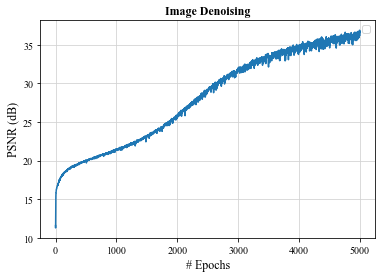

In [ ]:
font = {'font': 'Times New Roman', 'size': 12}

plt.figure()
axfont = {'family' : 'Times New Roman', 'weight' : 'regular', 'size'   : 10}
plt.rc('font', **axfont)

plt.plot(np.arange(len(truth_psnr[:-1])),   truth_psnr[:-1])
plt.xlabel('# Epochs', fontdict=font)
plt.ylabel('PSNR (dB)', fontdict=font)
plt.title('Image Denoising', fontdict={'family': 'Times New Roman', 'size': 12, 'weight': 'bold'})
plt.legend()
plt.grid(True, color='lightgray')

plt.show()
print('Max PSNR:',np.array(truth_psnr[:-1]).max())
plt.figure()
axfont = {'family' : 'Times New Roman', 'weight' : 'regular', 'size'   : 10}
plt.rc('font', **axfont)

plt.plot(np.arange(len(noise_psnr[:-1])),   noise_psnr[:-1])
plt.xlabel('# Epochs', fontdict=font)
plt.ylabel('PSNR (dB)', fontdict=font)
plt.title('Image Denoising', fontdict={'family': 'Times New Roman', 'size': 12, 'weight': 'bold'})
plt.legend()
plt.grid(True, color='lightgray')

plt.show()